In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
from datetime import datetime
from tqdm import tqdm

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [4]:
df = get_energy_data()

  0%|          | 0/255 [00:00<?, ?it/s]/var/folders/c7/nx3f8qlj38ld0jj0l_0nyp2h0000gn/T/ipykernel_4002/2942256061.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 255/255 [00:55<00:00,  4.60it/s]


In [12]:
df.head()

,gesamt
date_time,
2018-12-24 00:00:00,42.02925
2018-12-24 01:00:00,39.61025
2018-12-24 02:00:00,39.13875
2018-12-24 03:00:00,39.42100
2018-12-24 04:00:00,40.74775


Rename column for convenience

In [9]:
df = df.rename(columns={"Netzlast_Gesamt": "gesamt"})

Rescale Netzlast so it fits requirements

In [11]:
df['gesamt'] = df['gesamt'] / 1000

Check dtypes and if columns contain and missing values

In [13]:
df.dtypes

gesamt    float64
dtype: object

In [14]:
df.isna().any()

gesamt    False
dtype: bool

Define weekday column

In [15]:
df["weekday"] = df.index.weekday #Monday=0, Sunday=6
#df["time"] = df.index.strftime("%H:%M")

Lead times are

In [16]:
horizons_def = [36, 40, 44, 60, 64, 68]#[24 + 12*i for i in range(5)]
horizons_def

[36, 40, 44, 60, 64, 68]

Adapt horzions so they actually fit

In [17]:
horizons = [h+1 for h in horizons_def]
horizons

[37, 41, 45, 61, 65, 69]

In [18]:
def get_date_from_horizon(last_ts, horizon):
    return last_ts + pd.DateOffset(hours=horizon)

In [40]:
LAST_IDX = -39
LAST_DATE = df.iloc[LAST_IDX].name

Get time and date that correspond to the lead times (starting at the last observation in our data which should be the respective thursday 0:00)  
*Attention*: if the last timestamp in the data is not thursday 0:00, you have to adjust your lead times accordingly

In [41]:
horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons]
horizon_date

[Timestamp('2023-11-10 12:00:00'),
 Timestamp('2023-11-10 16:00:00'),
 Timestamp('2023-11-10 20:00:00'),
 Timestamp('2023-11-11 12:00:00'),
 Timestamp('2023-11-11 16:00:00'),
 Timestamp('2023-11-11 20:00:00')]

quantile levels

In [42]:
tau = [.025, .25, .5, .75, .975]

In [43]:
#rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

In [47]:
last_t = 100
for i,d in enumerate(horizon_date):
    
    weekday = d.weekday()
    hour = d.hour
    
    df_tmp = df.iloc[:LAST_IDX]
    
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    pred_baseline[i,:] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)
    

date_time
2018-12-24 00:00:00    False
2018-12-24 01:00:00    False
2018-12-24 02:00:00    False
2018-12-24 03:00:00    False
2018-12-24 04:00:00    False
                       ...  
2023-11-08 18:00:00    False
2023-11-08 19:00:00    False
2023-11-08 20:00:00    False
2023-11-08 21:00:00    False
2023-11-08 22:00:00    False
Freq: H, Name: weekday, Length: 42743, dtype: bool
date_time
2018-12-24 00:00:00    False
2018-12-24 01:00:00    False
2018-12-24 02:00:00    False
2018-12-24 03:00:00    False
2018-12-24 04:00:00    False
                       ...  
2023-11-08 18:00:00    False
2023-11-08 19:00:00    False
2023-11-08 20:00:00    False
2023-11-08 21:00:00    False
2023-11-08 22:00:00    False
Freq: H, Name: weekday, Length: 42743, dtype: bool
date_time
2018-12-24 00:00:00    False
2018-12-24 01:00:00    False
2018-12-24 02:00:00    False
2018-12-24 03:00:00    False
2018-12-24 04:00:00    False
                       ...  
2023-11-08 18:00:00    False
2023-11-08 19:00:00    Fals

In [24]:
pred_baseline

array([[32.96196875, 35.6086875 , 37.6355    , 42.133625  , 48.7684625 ],
       [33.91830625, 35.7955625 , 37.83275   , 41.897875  , 47.5838375 ],
       [42.338475  , 45.7920625 , 48.115125  , 52.212     , 58.9526625 ],
       [35.0606    , 37.48425   , 39.875875  , 43.735875  , 50.6902375 ],
       [36.48033125, 49.334625  , 53.064125  , 57.11775   , 64.10020625],
       [46.431225  , 59.9011875 , 63.500375  , 67.05875   , 74.25583125]])

Visually check if quantiles make sense

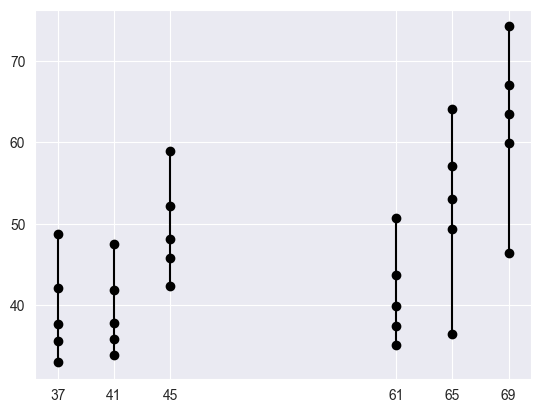

In [25]:
x = horizons
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

In [26]:
from datetime import datetime, date, timedelta
date_str = datetime.today().strftime('%Y%m%d')

In [29]:
date_str = date.today() #- timedelta(days=1)
date_str = date_str.strftime('%Y-%m-%d')
date_str

'2023-11-10'

In [30]:
df_sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons_def],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-10,energy,36 hour,32.961969,35.608688,37.635500,42.133625,48.768462
1,2023-11-10,energy,40 hour,33.918306,35.795563,37.832750,41.897875,47.583838
2,2023-11-10,energy,44 hour,42.338475,45.792063,48.115125,52.212000,58.952662
3,2023-11-10,energy,60 hour,35.060600,37.484250,39.875875,43.735875,50.690238
4,2023-11-10,energy,64 hour,36.480331,49.334625,53.064125,57.117750,64.100206
5,2023-11-10,energy,68 hour,46.431225,59.901187,63.500375,67.058750,74.255831


In [29]:
#need to change this
PATH = "/save/to/path"


df_sub.to_csv(PATH+date_str+"_power_benchmark.csv", index=False)